# Light curve prediction by the autoencoder model

In this notebook we show the possibility of the QSO light curve prediction by the autoencoder model. 
The autoencode is trained by the $80\%$ of the full length of each light curves, 
and then we check the accuracy of the prediction by comparing it with the $20\%$ dataset which we didn't use for the training. 

We tried two methods for the prediction  

(1) with the encoded features derived from the $80\%$ dataset and fixed $\Delta t$ (= median of the $\Delta t$), 
and 

(2) with the encoded features updated by the $20\%$ dataset and real $\Delta t$. 

The both of the prediction looks good, but we have to check the performance of it quantitatively (by $\chi_{\mathrm{red}}$ or something?). 

In [1]:
import sys
sys.path.append('./IrregularTimeSeriesAutoencoder')
import numpy as np
import pandas as pd
from keras.layers import (Input, Dense, TimeDistributed, LSTM, GRU, Dropout, merge,
                          Flatten, RepeatVector, Recurrent, Bidirectional, SimpleRNN)
from keras.models import Model
import keras_util as ku
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image, display_png, display_pdf

Using TensorFlow backend.
/Users/tachibana/anaconda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


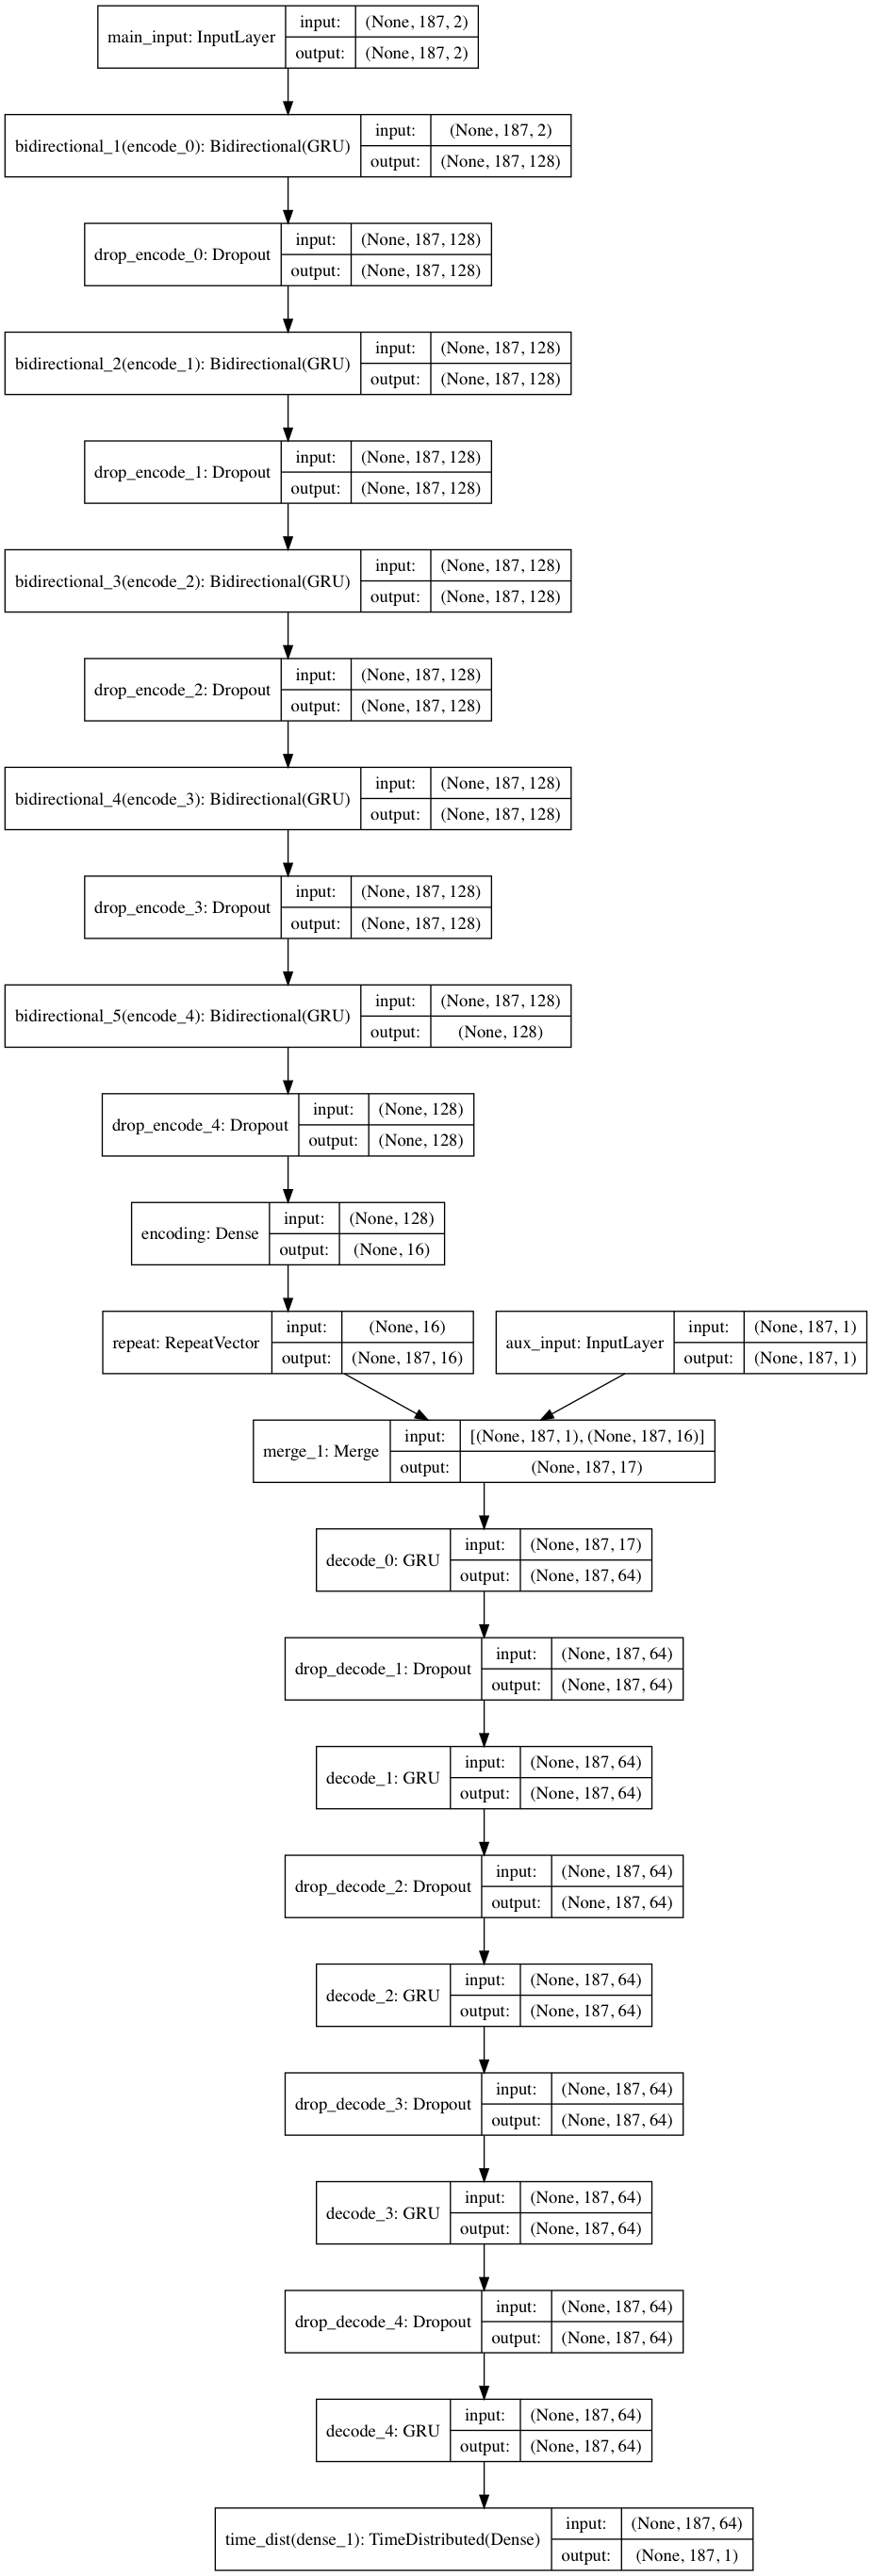

In [179]:
display_png(Image('./model.png'))

Functions used in this notebook

In [180]:
def encoder(model_input, layer, size, num_layers, drop_frac=0.25, output_size=None,
            bidirectional=False, **parsed_args):
    if output_size is None:
        output_size = size
    encode = model_input
    for i in range(num_layers):
        wrapper = Bidirectional if bidirectional else lambda x: x
        encode = wrapper(layer(size, name='encode_{}'.format(i),
                               return_sequences=(i < num_layers - 1)))(encode)
        if drop_frac > 0.0:
            encode = Dropout(drop_frac, name='drop_encode_{}'.format(i))(encode)
    encode = Dense(output_size, activation='linear', name='encoding')(encode)
    return encode

def decoder(encode, layer, n_step, size, num_layers, drop_frac=0.25, aux_input=None,
            bidirectional=False, **parsed_args):
    
    decode = RepeatVector(n_step, name='repeat')(encode)
    if aux_input is not None:
        decode = merge([aux_input, decode], mode='concat')

    for i in range(num_layers):
        if drop_frac > 0.0 and i > 0:  # skip these for first layer for symmetry
            decode = Dropout(drop_frac, name='drop_decode_{}'.format(i))(decode)
        wrapper = Bidirectional if bidirectional else lambda x: x
        decode = wrapper(layer(size, name='decode_{}'.format(i),
                               return_sequences=True))(decode)

    decode = TimeDistributed(Dense(1, activation='linear'), name='time_dist')(decode)
    return decode

import subprocess
def load_lcs(pass_to_lc_dir):
    command = 'ls ' + str(pass_to_lc_dir)
    lc_files = subprocess.run(command, stdout=subprocess.PIPE, shell=True).stdout.decode('utf-8').split('\n')
    del lc_files[len(lc_files)-1]
    print('Loading %d data:'%len(lc_files))
    X = [np.r_[np.array(pd.read_csv('./lcs/'+str(lc_files[i]), header=None, sep=' ')).tolist()] for i in range(len(lc_files))]
    print('Finish.')
    return  X

def preprocess(X_raw, m_max=np.inf):
    X = X_raw.copy()
    wrong_units =  np.all(np.isnan(X[:, :, 1])) | (np.nanmax(X[:, :, 1], axis=1) > m_max)
    X = X[~wrong_units, :, :]
    X[:, :, 0] = ku.times_to_lags(X[:, :, 0])
    means = np.atleast_2d(np.nanmean(X[:, :, 1], axis=1)).T
    X[:, :, 1] -= means
    scales = np.atleast_2d(np.nanstd(X[:, :, 1], axis=1)).T
    X[:, :, 1] /= scales
    errors = X[:, :, 2] / scales
    X = X[:, :, :2]
    return X, means, scales, errors, wrong_units

from keras.callbacks import (Callback, TensorBoard, EarlyStopping,
                             ModelCheckpoint, CSVLogger, ProgbarLogger)
from keras_tqdm import TQDMCallback
import sys
import csv
from collections import Iterable, OrderedDict
import datetime

class Progbar(TQDMCallback):  # redirect TQDMCallback to stdout
    def __init__(self):
        TQDMCallback.__init__(self)
        self.output_file = sys.stdout
class TimedCSVLogger(CSVLogger):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        def handle_value(k):
            is_zero_dim_ndarray = isinstance(k, np.ndarray) and k.ndim == 0
            if isinstance(k, Iterable) and not is_zero_dim_ndarray:
                return '"[%s]"' % (', '.join(map(str, k)))
            else:
                return k

        if not self.writer:
            self.keys = sorted(logs.keys())

            class CustomDialect(csv.excel):
                delimiter = self.sep

            self.writer = csv.DictWriter(self.csv_file,
                                         fieldnames=['epoch', 'time'] + self.keys,
                                         dialect=CustomDialect)
            if self.append_header:
                self.writer.writeheader()

        row_dict = OrderedDict({'epoch': epoch, 'time': str(datetime.datetime.now())})
        row_dict.update((key, handle_value(logs[key])) for key in self.keys)
        self.writer.writerow(row_dict)
        self.csv_file.flush()
class LogDirLogger(Callback):
    def __init__(self, log_dir):
        self.log_dir = log_dir 

    def on_epoch_begin(self, epoch, logs=None):
        print('\n' + self.log_dir + '\n')

In [13]:
X_list = load_lcs('./lcs/')

Loading 4227 data:
Finish.


In [15]:
np.random.shuffle(X_list)
X_list[0][0:3]

array([[  5.36273987e+04,   1.94201389e+01,   1.48311956e-01],
       [  5.36483622e+04,   1.94321152e+01,   1.53326938e-01],
       [  5.36543441e+04,   1.97072892e+01,   1.69919682e-01]])

In [16]:
import copy
X_list_org = copy.deepcopy(X_list) # save the original dataset 

In [17]:
for i in range(len(X_list)):
    if len(X_list[i])==187:
        print(i)
        k=i

3896


In [18]:
for i in range(len(X_list)):
    if i != k:
        X_list[i] = X_list[i][0:int(len(X_list[i])*0.8)]

In [19]:
from keras.preprocessing.sequence import pad_sequences
X_raw = pad_sequences(X_list, value=np.nan, dtype='float', padding='post')

In [22]:
X, means, scales, errors, wrong_units = preprocess(X_raw)
main_input = Input(shape=(X.shape[1], 2), name='main_input') #(lag, mag)
aux_input = Input(shape=(X.shape[1], 1), name='aux_input') #(lag)
model_input = [main_input, aux_input]

/Users/tachibana/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: All-NaN slice encountered
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/tachibana/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/tachibana/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/Users/tachibana/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/tachibana/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/tachibana/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: Ru

In [23]:
sample_weight = 1. / errors
sample_weight[np.isnan(sample_weight)] = 0.0
X[np.isnan(X)] = 0.

In [24]:
encode = encoder(main_input, layer=GRU, size=64, num_layers=5, output_size=16, drop_frac=0.25, bidirectional=True)
decode = decoder(encode, layer=GRU, size=64, num_layers=5,  n_step=X.shape[1], drop_frac=0.25, aux_input=aux_input)
model = Model(model_input, decode)

/Users/tachibana/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  
/Users/tachibana/anaconda/envs/py36/lib/python3.6/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [25]:
lr = 1e-3 #learning rate 

In [26]:
from keras.optimizers import Adam
import os

optimizer = Adam(lr=lr)

log_dir = os.path.join(os.getcwd(), 'keras_logs', 'test')
log_dir += "_ft{:1.0e}".format(lr).replace('e-', 'm')
weights_path = os.path.join(log_dir, 'weights.h5')

print("""log directory: {0} \n
weight pass: {1} """.format(log_dir, weights_path))

log directory: /Users/tachibana/Documents/AutoEncoder_180312/keras_logs/test_ft1m03 

weight pass: /Users/tachibana/Documents/AutoEncoder_180312/keras_logs/test_ft1m03/weights.h5 


In [27]:
#model.load_weights(weights_path)
model.compile(optimizer=optimizer, loss='mse',  sample_weight_mode='temporal')

In [28]:
import shutil
shutil.rmtree(log_dir, ignore_errors=True)
os.makedirs(log_dir)

In [181]:
"""
history = model.fit({'main_input': X, 'aux_input': np.delete(X, 1, axis=2)},
                    X[:, :, [1]], 
                    nb_epoch=256, 
                    batch_size=256,
                    sample_weight=sample_weight,
                    callbacks=[Progbar(),
                           TensorBoard(log_dir=log_dir, write_graph=False),
                           TimedCSVLogger(os.path.join(log_dir, 'training.csv'), append=True),
                           ModelCheckpoint(weights_path, save_weights_only=True),
                           LogDirLogger(log_dir)], 
                    verbose=False,
                    validation_split=0.0,
                    validation_data=None)
"""

"\nhistory = model.fit({'main_input': X, 'aux_input': np.delete(X, 1, axis=2)},\n                    X[:, :, [1]], \n                    nb_epoch=256, \n                    batch_size=256,\n                    sample_weight=sample_weight,\n                    callbacks=[Progbar(),\n                           TensorBoard(log_dir=log_dir, write_graph=False),\n                           TimedCSVLogger(os.path.join(log_dir, 'training.csv'), append=True),\n                           ModelCheckpoint(weights_path, save_weights_only=True),\n                           LogDirLogger(log_dir)], \n                    verbose=False,\n                    validation_split=0.0,\n                    validation_data=None)\n"

In [31]:
import glob

def parse_logs(log_files, max_epoch=1000):
    logs = [pd.read_csv(f, index_col='epoch', parse_dates=[1]) for f in log_files]
    for log, f in zip(logs, log_files):
        run = f.split('/')[-2]
        log.drop(log.index[log.index > max_epoch], axis=0, inplace=True)
        if 'time' not in log:
            raise ValueError("Missing times from {}".format(f))
        log.columns = ['time', run + ' Train', run + ' Valid']
        log['time'] = log['time'].values.astype(float)
        log['time'] = (log['time'] - log['time'].min()) / 1e9
    step_logs = pd.concat([l.drop('time', axis=1, inplace=False) for l in logs], axis=1)
    time_logs = pd.concat([l.set_index('time') for l in logs], axis=1)
    
    return step_logs, time_logs

In [33]:
train = pd.read_csv('./keras_logs/test_ft1m03_64_5_16_0.8/training.csv')

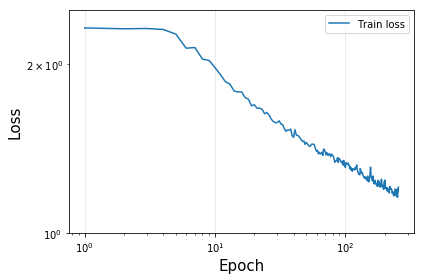

In [36]:
plt.plot(train.epoch, train.loss, label='Train loss')
#plt.plot(train.epoch, train.val_loss, label='Validation loss')
plt.yscale('log'); plt.xscale('log')
plt.ylim(1, 2.5)
plt.xlabel('Epoch', fontsize=15); plt.ylabel('Loss', fontsize=15)
plt.legend(loc='best')
plt.grid(lw=0.5, alpha=0.5)
plt.tight_layout()
plt.show()

Although the training is not enough because of the time constrain, the final loss value is not bad ($\sim 1.15$). 
We need more training epoch (> 1024) to get the final result. 

In [37]:
#model.load_weights(weights_path)
#model.compile(optimizer=optimizer, loss='mse',  sample_weight_mode='temporal')

In [38]:
encode_model = Model(input=model.input, output=model.get_layer('encoding').output)
decode_model = Model(input=model.input, output=model.output)
encoding = encode_model.predict({'main_input': X, 'aux_input': np.delete(X, 1, axis=2)})
decoding = decode_model.predict({'main_input': X, 'aux_input': np.delete(X, 1, axis=2)})

/Users/tachibana/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("en...)`
  """Entry point for launching an IPython kernel.
/Users/tachibana/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("ti...)`
  


Taking decoder from the whole model (from 'decode_0' to the final layer in the figure shown in the top of the notebook). 

In [43]:
model_input_decoder = Input(shape=(X.shape[1], encoding.shape[1]+1), name='decoder_input')

num_layer = 5

# taking the decoder out -> generator 
for i in np.arange(-2*num_layer, 0):
    if i == -2*num_layer:
        deco = model.layers[i](model_input_decoder)
    else: 
        deco= model.layers[i](deco)
        
generator = Model(model_input_decoder, deco)

Taking the output of the layer right before the decoder. 

In [44]:
_model = Model(input=model.input, output=model.layers[-11].get_output_at(0))
_ = _model.predict({'main_input': X, 'aux_input': np.delete(X, 1, axis=2)})

/Users/tachibana/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("me...)`
  """Entry point for launching an IPython kernel.


In [56]:
X_raw_org = pad_sequences(X_list_org, value=np.nan, dtype='float', padding='post')
X_org, means_org, scales_org, errors_org, wrong_units_org = preprocess(X_raw_org)

/Users/tachibana/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/tachibana/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [176]:
def calc_prediction_without_additional_data(k, gap_max='auto'):
    delta_t = np.empty_like(_[0])
    for i in range(len(_[k])):
        if _[k][i][0] != 0:
            delta_t[i] = _[k][i]
        else:
            if gap_max == 'auto':
                gap_max = np.median(X[k][:,0][np.nonzero(X[k][:,0])]) 
                #print(gap_max)
            delta_t[i][0] = gap_max#np.random.rand(1)*gap_max
            delta_t[i][1:len(delta_t[i])] = _[k][i][1:len(delta_t[i])]

    mag = X[k][:,1]*scales[k]+means[k]
    error_mag = errors[k]*scales[k]
    mag_org = X_org[k][:,1]*scales_org[k]+means_org[k]
    error_mag_org = errors_org[k]*scales_org[k]    
    _pred = generator.predict(delta_t[np.newaxis, :, :])
    pred = _pred[0]*scales[k]+means[k]
    
    return(np.cumsum(delta_t[:,0]), pred, mag, error_mag, mag_org, error_mag_org)

### Prediction without the information of the 20$\%$ dataset

We first tried to predict the behabiour of the light curve by using the encoded fetures obtained by the 80$\%$ dataset. 
The features and the $\Delta t$ is fixed to that obtained by the 80$\%$ dataset and $median(\Delta t)$, respectively. 

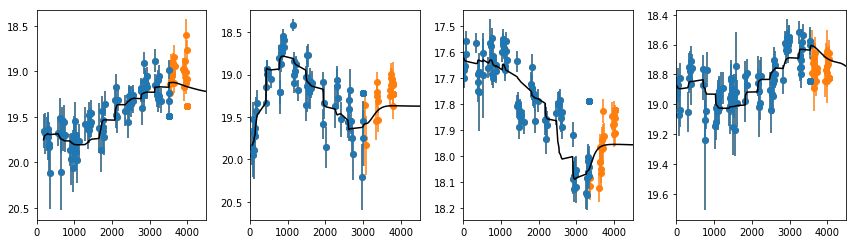

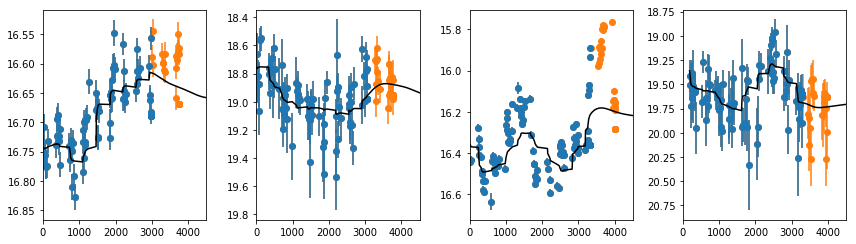

In [182]:
xlims = [0, 4500]

ind_list_example = [6, 11, 1000, 1100]

plt.figure(figsize=(12, 3.5))

plt.subplot(1,4,1)
k = ind_list_example[0]
t_pred, mag_pred, mag, error_mag, mag_org, error_mag_org =\
    calc_prediction_without_additional_data(k)

plt.plot(t_pred, mag_pred, zorder=3, color='k')
plt.errorbar(np.cumsum(X[k][:,0]), mag, yerr=error_mag, fmt='o', zorder=2)
plt.errorbar(np.cumsum(X_org[k][:,0]), mag_org, yerr=error_mag_org, fmt='o', zorder=1)
plt.ylim(plt.ylim()[::-1])
plt.xlim(xlims)

plt.subplot(1,4,2)
k = ind_list_example[1]
t_pred, mag_pred, mag, error_mag, mag_org, error_mag_org =\
    calc_prediction_without_additional_data(k)

plt.plot(t_pred, mag_pred, zorder=3, color='k')
plt.errorbar(np.cumsum(X[k][:,0]), mag, yerr=error_mag, fmt='o', zorder=2)
plt.errorbar(np.cumsum(X_org[k][:,0]), mag_org, yerr=error_mag_org, fmt='o', zorder=1)
plt.ylim(plt.ylim()[::-1])
plt.xlim(xlims)

plt.subplot(1,4,3)
k = ind_list_example[2]
t_pred, mag_pred, mag, error_mag, mag_org, error_mag_org =\
    calc_prediction_without_additional_data(k)

plt.plot(t_pred, mag_pred, zorder=3, color='k')
plt.errorbar(np.cumsum(X[k][:,0]), mag, yerr=error_mag, fmt='o', zorder=2)
plt.errorbar(np.cumsum(X_org[k][:,0]), mag_org, yerr=error_mag_org, fmt='o', zorder=1)
plt.ylim(plt.ylim()[::-1])
plt.xlim(xlims)

plt.subplot(1,4,4)
k = ind_list_example[3]
t_pred, mag_pred, mag, error_mag, mag_org, error_mag_org =\
    calc_prediction_without_additional_data(k)

plt.plot(t_pred, mag_pred, zorder=3, color='k')
plt.errorbar(np.cumsum(X[k][:,0]), mag, yerr=error_mag, fmt='o', zorder=2)
plt.errorbar(np.cumsum(X_org[k][:,0]), mag_org, yerr=error_mag_org, fmt='o', zorder=1)
plt.ylim(plt.ylim()[::-1])
plt.xlim(xlims)

plt.tight_layout()
plt.show()

ind_list_example = [203, 230, 1027, 2104, 4002]

plt.figure(figsize=(12, 3.5))

plt.subplot(1,4,1)
k = ind_list_example[0]
t_pred, mag_pred, mag, error_mag, mag_org, error_mag_org =\
    calc_prediction_without_additional_data(k)

plt.plot(t_pred, mag_pred, zorder=3, color='k')
plt.errorbar(np.cumsum(X[k][:,0]), mag, yerr=error_mag, fmt='o', zorder=2)
plt.errorbar(np.cumsum(X_org[k][:,0]), mag_org, yerr=error_mag_org, fmt='o', zorder=1)
plt.ylim(plt.ylim()[::-1])
plt.xlim(xlims)

plt.subplot(1,4,2)
k = ind_list_example[1]
t_pred, mag_pred, mag, error_mag, mag_org, error_mag_org =\
    calc_prediction_without_additional_data(k)

plt.plot(t_pred, mag_pred, zorder=3, color='k')
plt.errorbar(np.cumsum(X[k][:,0]), mag, yerr=error_mag, fmt='o', zorder=2)
plt.errorbar(np.cumsum(X_org[k][:,0]), mag_org, yerr=error_mag_org, fmt='o', zorder=1)
plt.ylim(plt.ylim()[::-1])
plt.xlim(xlims)

plt.subplot(1,4,3)
k = ind_list_example[2]
t_pred, mag_pred, mag, error_mag, mag_org, error_mag_org =\
    calc_prediction_without_additional_data(k)

plt.plot(t_pred, mag_pred, zorder=3, color='k')
plt.errorbar(np.cumsum(X[k][:,0]), mag, yerr=error_mag, fmt='o', zorder=2)
plt.errorbar(np.cumsum(X_org[k][:,0]), mag_org, yerr=error_mag_org, fmt='o', zorder=1)
plt.ylim(plt.ylim()[::-1])
plt.xlim(xlims)

plt.subplot(1,4,4)
k = ind_list_example[3]
t_pred, mag_pred, mag, error_mag, mag_org, error_mag_org =\
    calc_prediction_without_additional_data(k)

plt.plot(t_pred, mag_pred, zorder=3, color='k')
plt.errorbar(np.cumsum(X[k][:,0]), mag, yerr=error_mag, fmt='o', zorder=2)
plt.errorbar(np.cumsum(X_org[k][:,0]), mag_org, yerr=error_mag_org, fmt='o', zorder=1)
plt.ylim(plt.ylim()[::-1])
plt.xlim(xlims)

plt.tight_layout()
plt.show()

Blue points show the dataset used for training, and orange points are the validation dataset to judge the performance of the prediction. The black line, which shows the decoded/predicted light curve, looks trace the real data point nicely for the most of light curves. We show some example of the prediction in figures in above.   

### Prediction with the information of the 20$\%$ dataset

We next tried to predict the behaviour of the 20$\%$ lightcurve by using the real magnitude and the real $\Delta t$. The encoded features are updated by the 20$\%$ dataset, so the prediction should be more precise than that without the information of the 20$\%$ dataset. 

In [164]:
X_org[np.isnan(X_org)] = 0.

In [165]:
decoding_org = decode_model.predict({'main_input': X_org, 'aux_input': np.delete(X_org, 1, axis=2)})

In [173]:
def calc_prediction_with_additional_data(k, gap_max='auto'):
    
    mag = X[k][:,1]*scales[k]+means[k]
    error_mag = errors[k]*scales[k]
    mag_org = X_org[k][:,1]*scales_org[k]+means_org[k]
    error_mag_org = errors_org[k]*scales_org[k]    
    pred = decoding_org[k]*scales_org[k]+means_org[k]
    
    return(np.cumsum(X_org[k][:,0])[0:(len(X_org[k][:,0]))], pred[0:(len(X_org[k][:,0]))], 
           mag, error_mag, mag_org, error_mag_org)

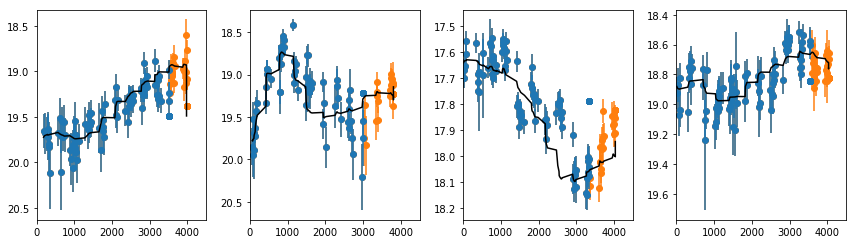

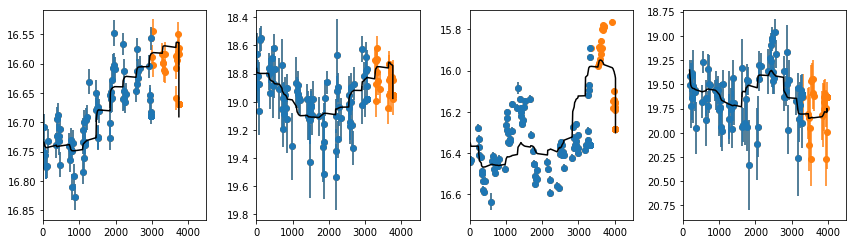

In [183]:
xlims = [0, 4500]

ind_list_example = [6, 11, 1000, 1100]

plt.figure(figsize=(12, 3.5))

plt.subplot(1,4,1)
k = ind_list_example[0]
t_pred, mag_pred, mag, error_mag, mag_org, error_mag_org =\
    calc_prediction_with_additional_data(k)

plt.plot(t_pred, mag_pred, zorder=3, color='k')
plt.errorbar(np.cumsum(X[k][:,0]), mag, yerr=error_mag, fmt='o', zorder=2)
plt.errorbar(np.cumsum(X_org[k][:,0]), mag_org, yerr=error_mag_org, fmt='o', zorder=1)
plt.ylim(plt.ylim()[::-1])
plt.xlim(xlims)

plt.subplot(1,4,2)
k = ind_list_example[1]
t_pred, mag_pred, mag, error_mag, mag_org, error_mag_org =\
    calc_prediction_with_additional_data(k)

plt.plot(t_pred, mag_pred, zorder=3, color='k')
plt.errorbar(np.cumsum(X[k][:,0]), mag, yerr=error_mag, fmt='o', zorder=2)
plt.errorbar(np.cumsum(X_org[k][:,0]), mag_org, yerr=error_mag_org, fmt='o', zorder=1)
plt.ylim(plt.ylim()[::-1])
plt.xlim(xlims)

plt.subplot(1,4,3)
k = ind_list_example[2]
t_pred, mag_pred, mag, error_mag, mag_org, error_mag_org =\
    calc_prediction_with_additional_data(k)

plt.plot(t_pred, mag_pred, zorder=3, color='k')
plt.errorbar(np.cumsum(X[k][:,0]), mag, yerr=error_mag, fmt='o', zorder=2)
plt.errorbar(np.cumsum(X_org[k][:,0]), mag_org, yerr=error_mag_org, fmt='o', zorder=1)
plt.ylim(plt.ylim()[::-1])
plt.xlim(xlims)

plt.subplot(1,4,4)
k = ind_list_example[3]
t_pred, mag_pred, mag, error_mag, mag_org, error_mag_org =\
    calc_prediction_with_additional_data(k)

plt.plot(t_pred, mag_pred, zorder=3, color='k')
plt.errorbar(np.cumsum(X[k][:,0]), mag, yerr=error_mag, fmt='o', zorder=2)
plt.errorbar(np.cumsum(X_org[k][:,0]), mag_org, yerr=error_mag_org, fmt='o', zorder=1)
plt.ylim(plt.ylim()[::-1])
plt.xlim(xlims)

plt.tight_layout()
plt.show()

xlims = [0, 4500]

ind_list_example = [203, 230, 1027, 2104, 4002]

plt.figure(figsize=(12, 3.5))

plt.subplot(1,4,1)
k = ind_list_example[0]
t_pred, mag_pred, mag, error_mag, mag_org, error_mag_org =\
    calc_prediction_with_additional_data(k)

plt.plot(t_pred, mag_pred, zorder=3, color='k')
plt.errorbar(np.cumsum(X[k][:,0]), mag, yerr=error_mag, fmt='o', zorder=2)
plt.errorbar(np.cumsum(X_org[k][:,0]), mag_org, yerr=error_mag_org, fmt='o', zorder=1)
plt.ylim(plt.ylim()[::-1])
plt.xlim(xlims)

plt.subplot(1,4,2)
k = ind_list_example[1]
t_pred, mag_pred, mag, error_mag, mag_org, error_mag_org =\
    calc_prediction_with_additional_data(k)

plt.plot(t_pred, mag_pred, zorder=3, color='k')
plt.errorbar(np.cumsum(X[k][:,0]), mag, yerr=error_mag, fmt='o', zorder=2)
plt.errorbar(np.cumsum(X_org[k][:,0]), mag_org, yerr=error_mag_org, fmt='o', zorder=1)
plt.ylim(plt.ylim()[::-1])
plt.xlim(xlims)

plt.subplot(1,4,3)
k = ind_list_example[2]
t_pred, mag_pred, mag, error_mag, mag_org, error_mag_org =\
    calc_prediction_with_additional_data(k)

plt.plot(t_pred, mag_pred, zorder=3, color='k')
plt.errorbar(np.cumsum(X[k][:,0]), mag, yerr=error_mag, fmt='o', zorder=2)
plt.errorbar(np.cumsum(X_org[k][:,0]), mag_org, yerr=error_mag_org, fmt='o', zorder=1)
plt.ylim(plt.ylim()[::-1])
plt.xlim(xlims)

plt.subplot(1,4,4)
k = ind_list_example[3]
t_pred, mag_pred, mag, error_mag, mag_org, error_mag_org =\
    calc_prediction_with_additional_data(k)

plt.plot(t_pred, mag_pred, zorder=3, color='k')
plt.errorbar(np.cumsum(X[k][:,0]), mag, yerr=error_mag, fmt='o', zorder=2)
plt.errorbar(np.cumsum(X_org[k][:,0]), mag_org, yerr=error_mag_org, fmt='o', zorder=1)
plt.ylim(plt.ylim()[::-1])
plt.xlim(xlims)

plt.tight_layout()
plt.show()